In [67]:
from typing import Iterator, NamedTuple

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

import matplotlib.pyplot as plt

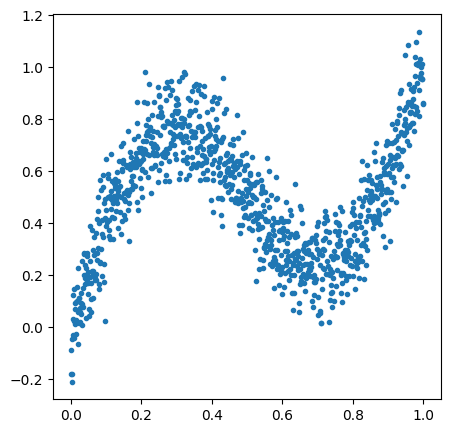

In [14]:
# Let's create some fake timeseries data that can have multiple y-values per x - so this is difficult
# to model with a simple MSE or single distribution network.

AMPLITUDE = 0.5

plt.figure(figsize=[5, 5])

NUM_TIME_POINTS = 1000

t=np.linspace(0., 1., NUM_TIME_POINTS)

# A simple sin function with some random noise
x = t + AMPLITUDE * np.sin(2*np.pi*t)+np.random.randn(NUM_TIME_POINTS)*0.1

plt.scatter(t, x, marker='.')

# Now make many of these for training

NUM_SAMPS = 20

X_Data = np.zeros((NUM_SAMPS, NUM_TIME_POINTS))
Y_Data = np.zeros((NUM_SAMPS, NUM_TIME_POINTS))

for i in range(NUM_SAMPS):
  X_Data[i, :] = t
  Y_Data[i, :] = t + AMPLITUDE * np.sin(2*np.pi*t)+np.random.randn(NUM_TIME_POINTS)*0.1

(20000, 1)


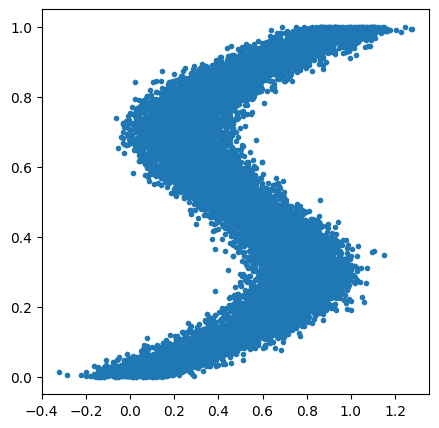

In [53]:
# standardize the data to prepare for inference
X_Data = jnp.expand_dims(X_Data.ravel(), axis=-1)
Y_Data = jnp.expand_dims(Y_Data.ravel(), axis=-1)

print(Y_Data.shape)

scaler = StandardScaler()

X_norm = scaler.fit_transform(X_Data)

# However, if we consider the inverse problem, we cannot fit a good model of the data with just a mean squared error loss.  To demonstrate,
# we retrain the network, swapping x, and y

X_Data_md = Y_Data
Y_Data_md = X_Data

plt.figure(figsize=[5, 5])

plt.scatter(X_Data_md, Y_Data_md, marker='.')

In [133]:
# It will be easier to feed into Jax/Haiku if we use the tensorflow dataset tools
BATCH = 128

data = tf.data.Dataset.from_tensor_slices((X_Data_md, Y_Data_md))
data = data.batch(BATCH)

In [164]:
# To prove that, let's try and train a MSE network in JAX - This code structure is right form the Haiku
# examples.

EPOCHS = 50

# Just a standard MLP with decent capacity - Not an amazing example of a neural network because the logits
# are arbitrary and MSE is not the best loss function to minimize
def net_fn(x: jnp.ndarray) -> jnp.ndarray:
  mlp = hk.Sequential([
      hk.Linear(256), jax.nn.relu,
      hk.Linear(128), jax.nn.relu,
      hk.Linear(1),
  ])
  return mlp(x)

network = hk.without_apply_rng(hk.transform(net_fn))
optimiser = optax.rmsprop(1e-3)

@jax.jit
def loss(params: hk.Params, batch: tuple) -> jnp.ndarray:
    # Trying to predict y
    logits = network.apply(params, batch[0])
    loss = optax.l2_loss(logits, batch[1])

    # MSE / L2_Loss
    #loss = (logits - batch[1])**2

    return jnp.mean(loss)

@jax.jit
def update(params: hk.Params, opt_state: optax.OptState, batch: tuple):
  grad = jax.grad(loss)(params, batch)
  updates, opt_state = optimiser.update(grad, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state

b = data.as_numpy_iterator()
params = network.init(jax.random.PRNGKey(seed=42), next(b)[0])
opt_state = optimiser.init(params)

for step in range(EPOCHS):
  data_iter = data.as_numpy_iterator()

  print({"Epoch": step})
  for b in data_iter:
    params, opt_state = update(params, opt_state, b)

  # Average loss?
  data_iter = data.as_numpy_iterator()
  total_loss = 0
  for b in data_iter:
    total_loss = total_loss + loss(params, b)

  print({ "loss": total_loss*BATCH/20000})


{'Epoch': 0}
{'loss': DeviceArray(0.11498474, dtype=float32)}
{'Epoch': 1}
{'loss': DeviceArray(0.08776518, dtype=float32)}
{'Epoch': 2}
{'loss': DeviceArray(0.08123527, dtype=float32)}
{'Epoch': 3}
{'loss': DeviceArray(0.07194888, dtype=float32)}
{'Epoch': 4}
{'loss': DeviceArray(0.07933691, dtype=float32)}
{'Epoch': 5}
{'loss': DeviceArray(0.09057539, dtype=float32)}
{'Epoch': 6}
{'loss': DeviceArray(0.09043313, dtype=float32)}
{'Epoch': 7}
{'loss': DeviceArray(0.08837131, dtype=float32)}
{'Epoch': 8}
{'loss': DeviceArray(0.08439216, dtype=float32)}
{'Epoch': 9}
{'loss': DeviceArray(0.07686059, dtype=float32)}
{'Epoch': 10}
{'loss': DeviceArray(0.07217483, dtype=float32)}
{'Epoch': 11}
{'loss': DeviceArray(0.06916259, dtype=float32)}
{'Epoch': 12}
{'loss': DeviceArray(0.06602625, dtype=float32)}
{'Epoch': 13}
{'loss': DeviceArray(0.0636435, dtype=float32)}
{'Epoch': 14}
{'loss': DeviceArray(0.06114837, dtype=float32)}
{'Epoch': 15}
{'loss': DeviceArray(0.05986515, dtype=float32)}
{'E

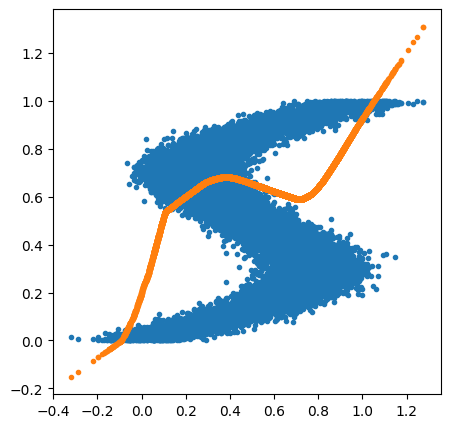

In [165]:
# You can see that because there are multiple y for every x, the network can only compute
# an approximate average with MSE, but it doesn't follow the curve.

y_pred = network.apply(params, X_Data_md)

plt.figure(figsize=[5, 5])

plt.scatter(X_Data_md[:, 0], Y_Data_md, marker='.')

plt.scatter(X_Data_md[:, 0], y_pred, marker='.')